In [1]:
import torch
import numpy as np
from scipy.special import legendre
import matplotlib.pyplot as plt

In [ ]:
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 775.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
from torchviz import make_dot

# Pytorch basics

In [ ]:
x = torch.tensor(1.0)
y = torch.tensor(2.0)
x, y

(tensor(1.), tensor(2.))

In [ ]:
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
z = x**2*y + y**2*x
z

tensor(6., grad_fn=<AddBackward0>)

In [ ]:
z.backward()
print(x.grad, y.grad)

tensor(8.) tensor(5.)


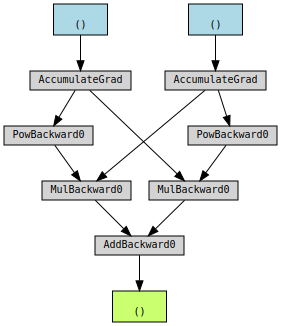

In [ ]:
make_dot(z)

# Optimization problems

In [ ]:
def f(x):
    return torch.sin(x)-2*torch.cos(x)**2

$$
min_x f(x)
$$

In [ ]:
def train(epochs, learning_rate):
    x = torch.tensor(1.5, requires_grad=True)
    path = []
    for epoch in range(epochs):
      path.append(x.detach().numpy())
      y = f(x)
      y.backward()
      x.data = x.data - learning_rate*x.grad
      x.grad.zero_()

    return path

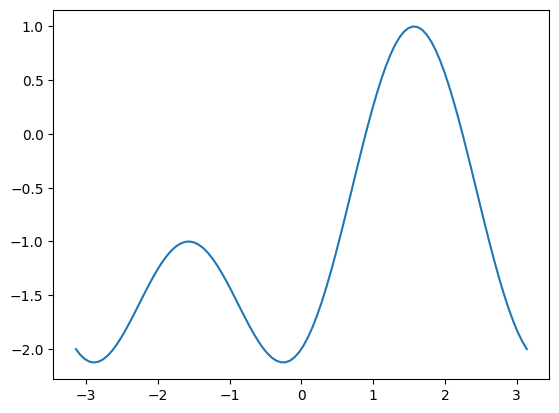

In [ ]:
xs = torch.linspace(-torch.pi, torch.pi, 100)
plt.plot(xs, torch.sin(xs)-2*torch.cos(xs)**2)

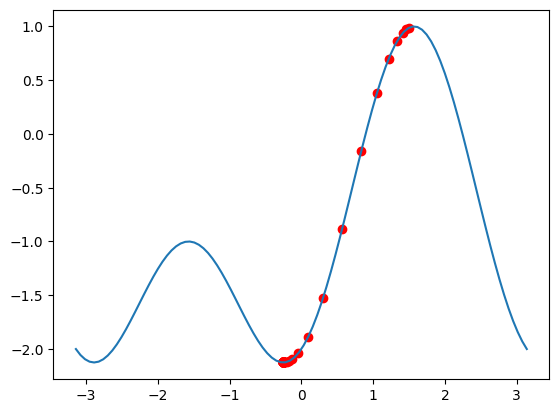

In [ ]:
path = train(100, 0.1)
plt.plot(xs, torch.sin(xs)-2*torch.cos(xs)**2)
plt.scatter(path, np.sin(path)-2*np.cos(path)**2, color='red')

# A learning problem

### Learning is just an optimization problem, of a specific type. They are a special family of optimization problems of the form:

$$
\min_w \frac{1}{m}\sum_{i=1}^{m} e(f_w(x_i), y_i)
$$

### Matrix completion

In [2]:
A = torch.tensor([[1,2,3],[2,4,6],[3,6,9]])
I = [(0,0,1,1,2,2), (0,2,1,2,0,1)]

In [5]:
list(zip(I[0], I[1]))

[(0, 0), (0, 2), (1, 1), (1, 2), (2, 0), (2, 1)]

In [8]:
def print_mat(A, I):
  for x in range(3):
    for y in range(3):
      if (x, y) in zip(I[0], I[1]):
        print(A[x,y].item(), end=" ")
      else:
        print("?", end=" ")
    print()
print_mat(A, I)

1 ? 3 
? 4 6 
3 6 ? 


In [ ]:
class H(torch.nn.Module):
    def __init__(self, d=1):
        super(H, self).__init__()
        self.w1 = torch.nn.Parameter(torch.randn(3,d))
        self.w2 = torch.nn.Parameter(torch.randn(d,3))

    def forward(self):
      return torch.matmul(self.w1, self.w2)

In [ ]:
def train(epochs, h, learning_rate):
    optimizer = torch.optim.SGD(h.parameters(), lr=learning_rate)
    LOSS = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = ((h.forward()[I[0], I[1]]-A[I[0], I[1]])**2).mean()
        loss.backward()
        optimizer.step()
        LOSS.append(loss.item())

    return LOSS

In [ ]:
torch.manual_seed(0)
h = H()

In [ ]:
train(1000, h, 0.01);

In [ ]:
h()

tensor([[1.0012, 2.0020, 3.0000],
        [2.0020, 4.0030, 5.9985],
        [2.9999, 5.9983, 8.9885]], grad_fn=<MmBackward0>)

# A regression problem

In [9]:
torch.manual_seed(0)
X = torch.randn(10)
Y = 10*X+5+torch.randn(10)

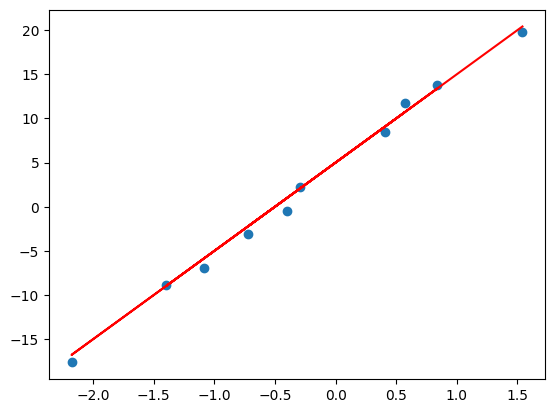

In [10]:
plt.plot(X, Y, 'o')
plt.plot(X, 10*X+5, 'r')

In [11]:
class Net(torch.nn.Module):
    def __init__(self, d=1):
        super(Net, self).__init__()
        self.w1 = torch.nn.Parameter(torch.randn(1))
        self.b = torch.nn.Parameter(torch.randn(1))
    def forward(self, X):
        return self.w1*X+self.b

In [12]:
def train(epochs, net, learning_rate):
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    LOSS = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = ((net.forward(X)-Y)**2).mean()
        loss.backward()
        optimizer.step()
        LOSS.append(loss.item())

    return LOSS

In [13]:
net = Net()

In [14]:
train(100, net, 0.01);

In [15]:
net.state_dict()

OrderedDict([('w1', tensor([9.0563])), ('b', tensor([3.5900]))])

<ipython-input-18-558fcb87234b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(X, net.forward(torch.tensor(X)).detach().numpy(), 'g:')


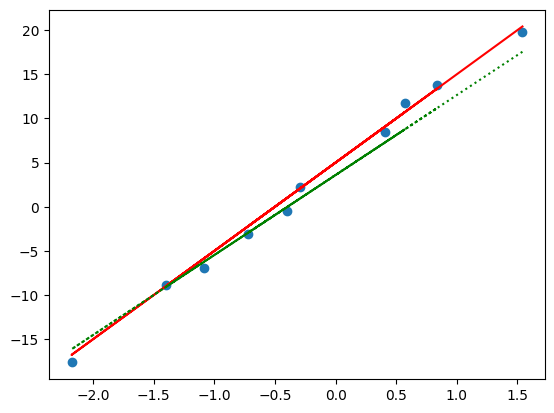

In [18]:
plt.plot(X, Y, 'o')
plt.plot(X, 10*X+5, 'r')
plt.plot(X, net.forward(torch.tensor(X)).detach().numpy(), 'g:')

# A classification problem

In [ ]:
# Create data for a simple classification problem
from sklearn.datasets import make_blobs
X, Y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=0)

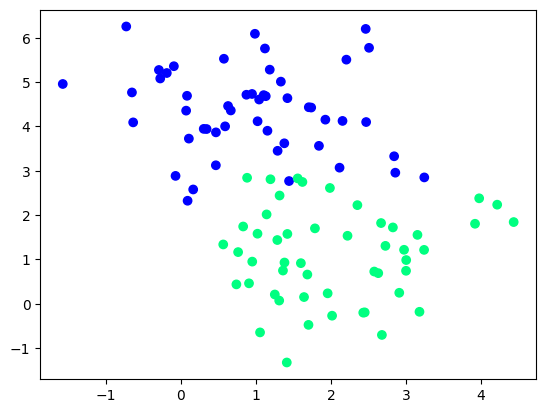

In [ ]:
# Plot the labeled data
plt.scatter(X[:,0], X[:,1], c=Y, cmap='winter')

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, d=1):
        super(Net, self).__init__()
        self.w = torch.nn.Parameter(torch.randn(2,1))
        self.b = torch.nn.Parameter(torch.randn(1))
    def forward(self, X):
        return torch.sigmoid(torch.matmul(X, self.w)+self.b)

In [ ]:
def train(epochs, net, X, Y, learning_rate):
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    LOSS = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        Y_hat = net.forward(X)
        loss = torch.nn.functional.binary_cross_entropy(Y_hat, Y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        LOSS.append(loss.item())

    return LOSS

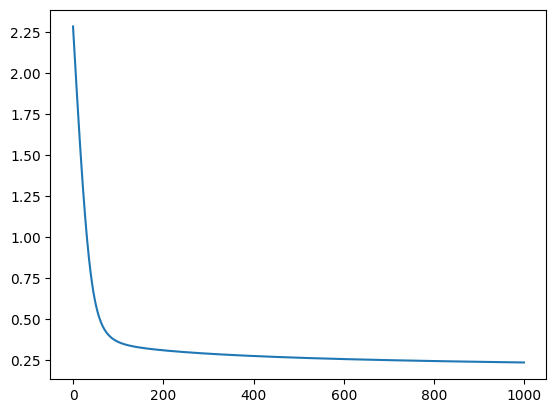

In [ ]:
net = Net()
LOSS = train(1000, net, torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32), 0.01)
plt.plot(LOSS)

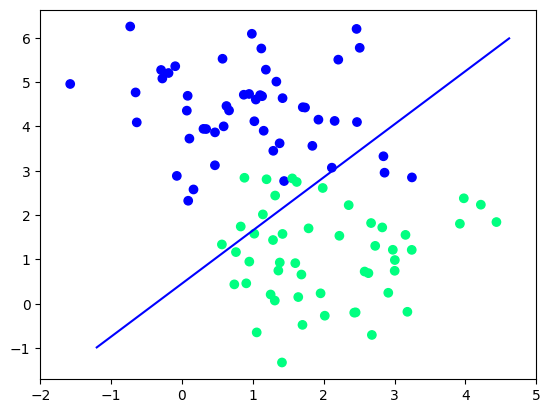

In [ ]:
plt.scatter(X[:,0], X[:,1], c=Y, cmap='winter')
# Create a x,y grid
x = np.linspace(-2, 5, 100)
y = np.linspace(-1, 6, 100)
xx, yy = np.meshgrid(x, y)
# Crate contour lines
Z = net.forward(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
Z = Z.detach().numpy().reshape(xx.shape)
# Plot the contour lines
plt.contour(xx, yy, Z, levels=[0.5], cmap='winter')

# When data is not linearly seperable

In [ ]:
# import polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
X_poly.shape

(100, 6)

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, d=1):
        super(Net, self).__init__()
        self.w = torch.nn.Parameter(torch.randn(6,1))

    def forward(self, X):
        return torch.sigmoid(torch.matmul(X, self.w))

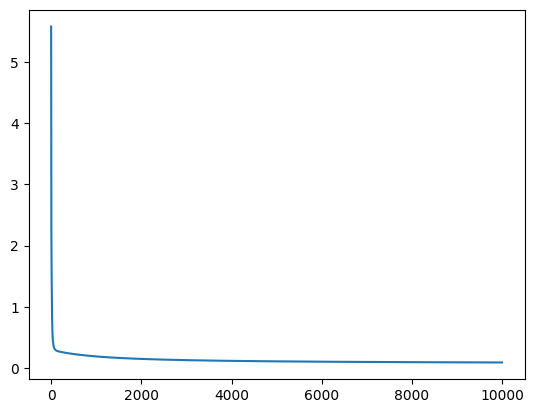

In [ ]:
net = Net()
LOSS = train(10000, net, torch.tensor(X_poly, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32), 0.01)
plt.plot(LOSS)

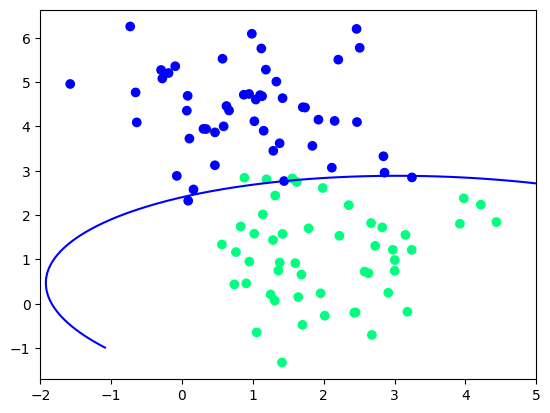

In [ ]:
plt.scatter(X[:,0], X[:,1], c=Y, cmap='winter')
# Create a x,y grid
x = np.linspace(-2, 5, 100)
y = np.linspace(-1, 6, 100)
xx, yy = np.meshgrid(x, y)
# Crate contour lines
Z = net.forward(torch.tensor(poly.transform(np.c_[xx.ravel(), yy.ravel()]), dtype=torch.float32))
Z = Z.detach().numpy().reshape(xx.shape)
# Plot the contour lines
plt.contour(xx, yy, Z, levels=[0.5], cmap='winter')

# The ingredients of a learning problem

1. A target function $f: \mathbb{R}^n \to \mathbb{R}^m$.

2. A parametric family $H = \{ \vec{w} \in \mathbb{R}^k : h(\cdot; \vec{w}) :  \mathbb{R}^n \to \mathbb{R}^m \}$

3. Error function $e: \mathbb{R}^m \times \mathbb{R}^m \to \mathbb{R}$

4. Data: $(x_1, y_1=f(x_1)), (x_2, y_2=f(x_2)), \ldots, (x_N, y_N=f(x_N))$  

Together these make up the optimization problem:

$$
\min_{\vec{w}} \frac{1}{N}\sum_{i=1}^{N} e(h(x_i; \vec{w}), y_i)
$$

5. An algorithm to find a min point.

# Possible target functions

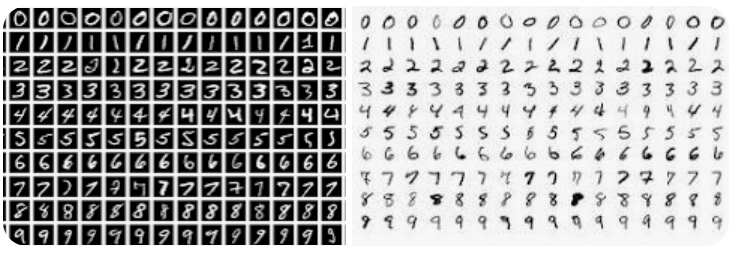

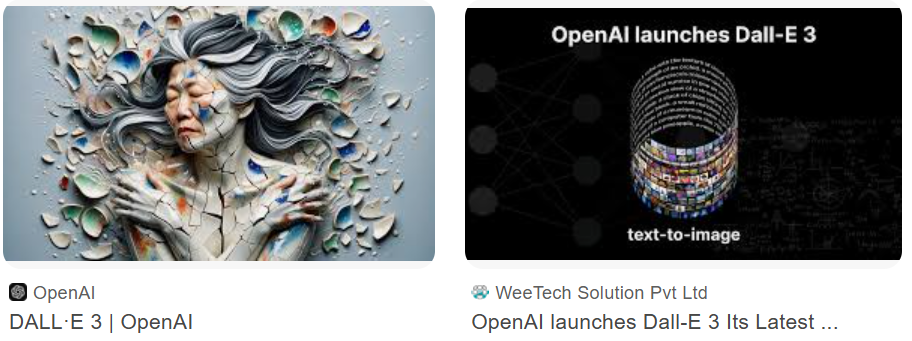

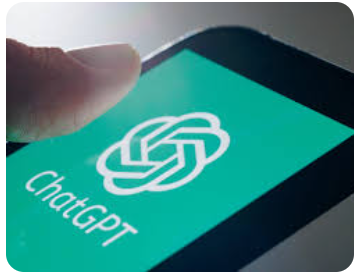

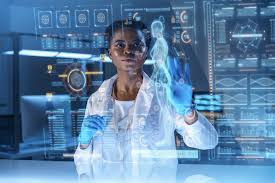

### An algorithm as a function

# Possible hypothesis classes

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.w = torch.nn.Parameter(torch.randn(10))
        self.b = torch.nn.Parameter(torch.randn(1))

    def forward(self, x):
        sum = torch.sin(x) + torch.cos(x)
        for i in range(2,11):
            sum += self.w[i-2]*torch.sin(i*x) + self.w[i-2]*torch.cos(i*x)
        return torch.sigmoid(sum[:,0] + sum[:,1] + torch.tensor(0.0))

In [ ]:
x = torch.tensor([[1.0, 2.0],[3.0,4.0],[5.0,6.0]])
net = Net()
net.forward(x).unsqueeze(1)

tensor([[0.7187],
        [0.8567],
        [0.0493]], grad_fn=<UnsqueezeBackward0>)

In [ ]:
def train(epochs, net, X, Y, learning_rate):
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    LOSS = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        Y_hat = net.forward(X)
        loss = torch.nn.functional.binary_cross_entropy(Y_hat.unsqueeze(1), Y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        LOSS.append(loss.item())

    return LOSS

In [ ]:
# Create data for a simple classification problem
from sklearn.datasets import make_blobs
X, Y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=0)

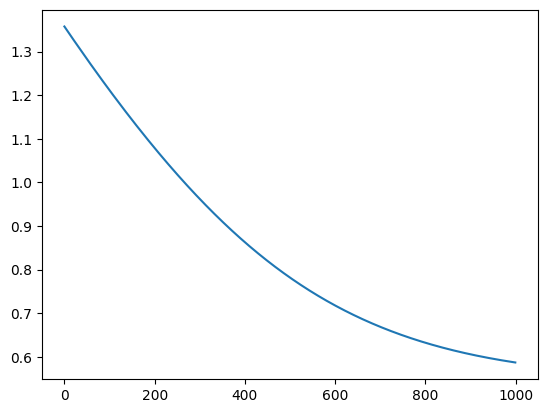

In [ ]:
net = Net()
LOSS = train(1000, net, torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32), 0.01)
plt.plot(LOSS)

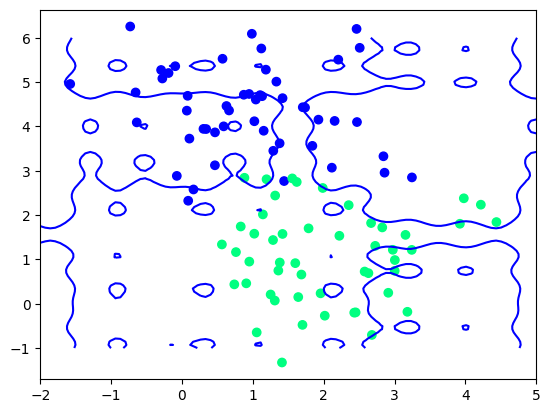

In [ ]:
plt.scatter(X[:,0], X[:,1], c=Y, cmap='winter')
# Create a x,y grid
x = np.linspace(-2, 5, 100)
y = np.linspace(-1, 6, 100)
xx, yy = np.meshgrid(x, y)
# Crate contour lines
Z = net.forward(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
Z = Z.detach().numpy().reshape(xx.shape)
# Plot the contour lines
plt.contour(xx, yy, Z, levels=[0.5], cmap='winter')

# Neural networks

In [19]:
import torch
import torch.nn as nn
import matplotlib.pylab as plt
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [20]:
# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    print(n_out, n_in)
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0

    #plot outputs as rows inputs as columns
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

In [21]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)
    plt.show()

In [22]:
# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

In [23]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

In [24]:
IMAGE_SIZE = 16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [25]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 59.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.34MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.76MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [26]:
validation_dataset = dsets.MNIST(root='./data', train=False, download=False, transform=composed)

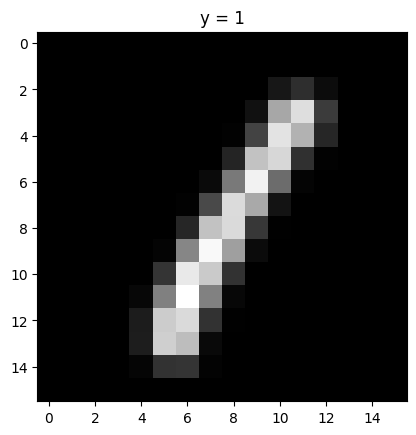

In [27]:
show_data(train_dataset[3])

In [28]:
class CNN(nn.Module):

    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    # Outputs in each steps
    def activations(self, x):
        #outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)

        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

In [29]:
model = CNN(out_1=16, out_2=32)

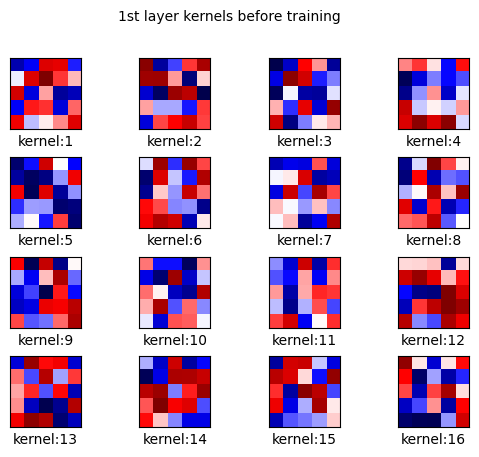

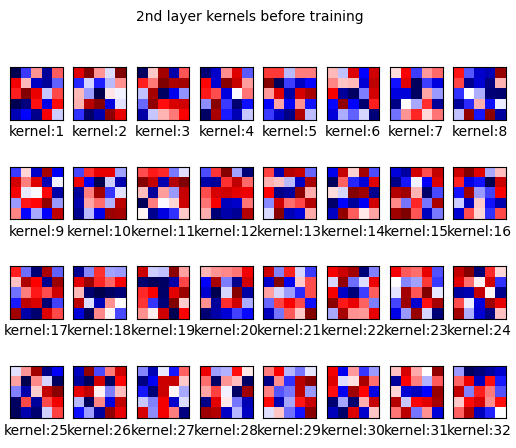

In [30]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

In [31]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [32]:
# Train the model

n_epochs=3
cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
COST=0

def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data

        cost_list.append(COST)
        correct=0
        #perform a prediction on the validation  data
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)

train_model(n_epochs)

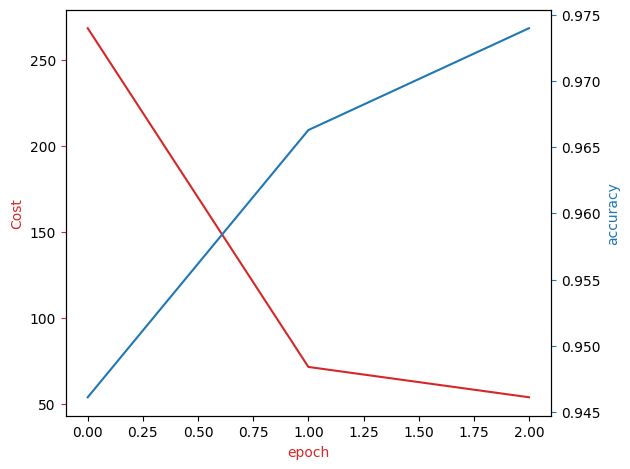

In [33]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

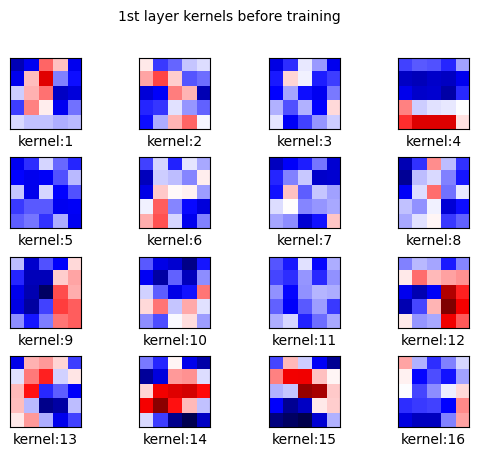

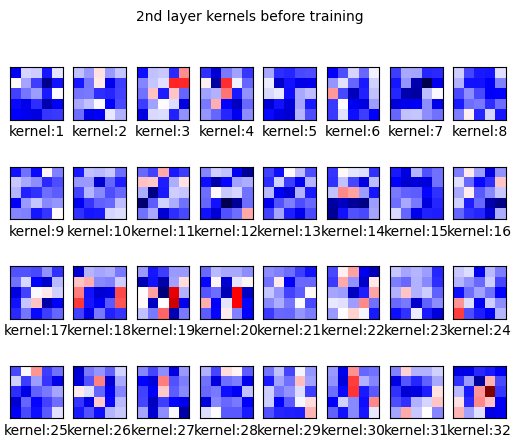

In [34]:
plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

In [35]:
model.state_dict()['cnn1.weight'].shape

torch.Size([16, 1, 5, 5])

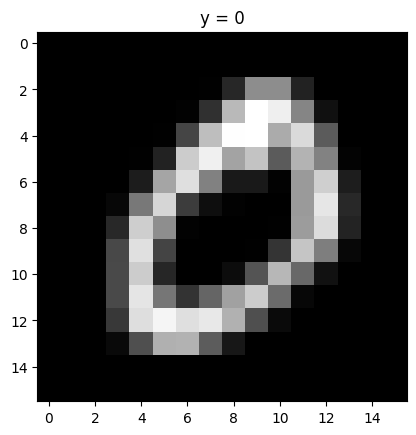

In [36]:
show_data(train_dataset[1])

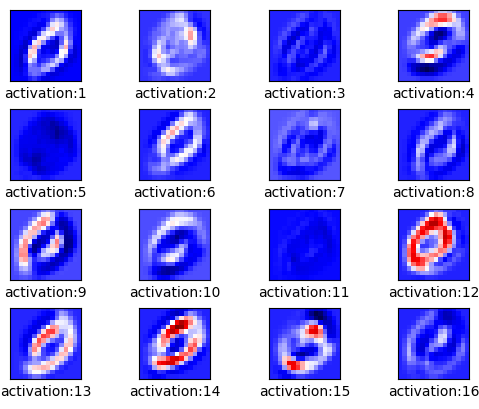

In [37]:
# Use the CNN activations class to see the steps
out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))
# Plot the outputs after the first CNN
plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

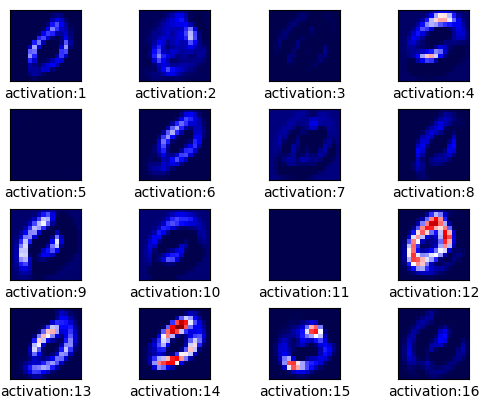

In [38]:
# Plot the outputs after the first Relu
plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

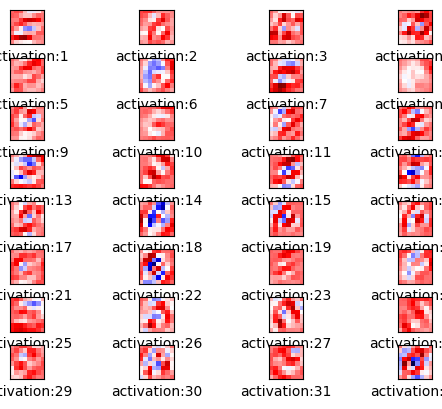

In [39]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

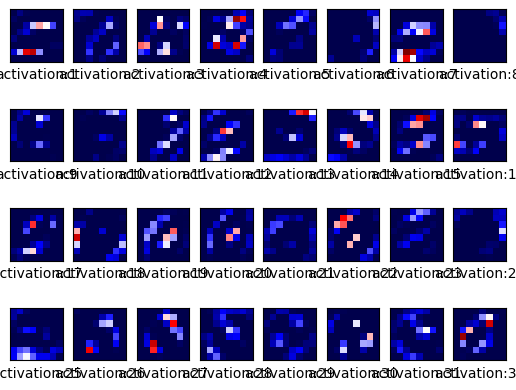

In [40]:
# Plot the outputs after the second Relu

plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

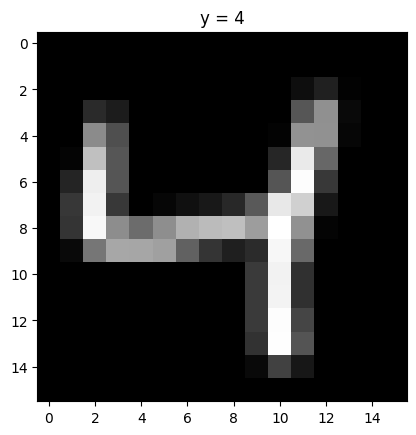

In [41]:
# Show the third image

show_data(train_dataset[2])

In [42]:
# Use the CNN activations class to see the steps

out = model.activations(train_dataset[2][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

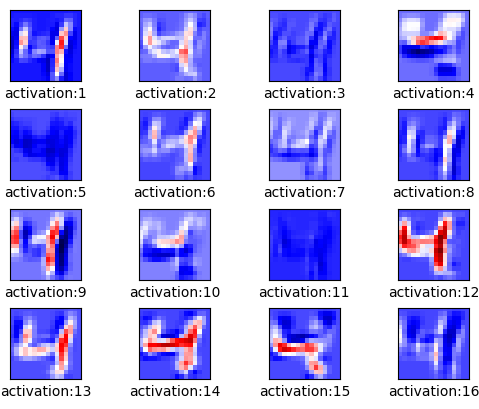

In [43]:
# Plot the outputs after the first CNN

plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

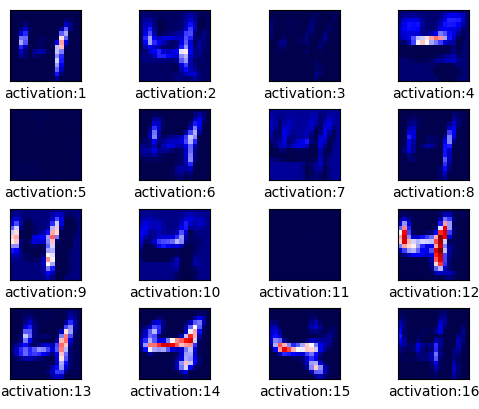

In [44]:
# Plot the outputs after the first Relu

plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

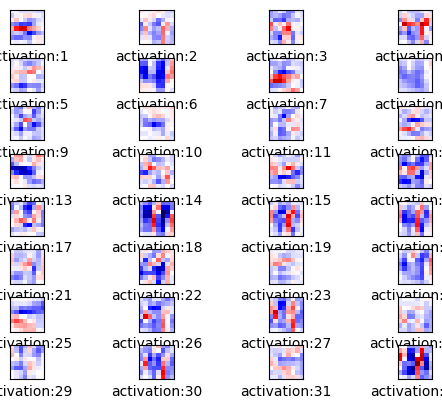

In [45]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

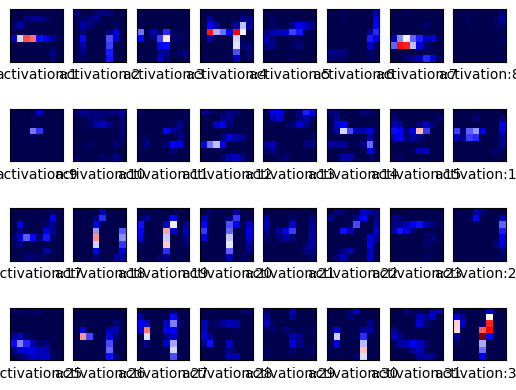

In [46]:
# Plot the outputs after the second Relu

plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")